In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb 
from sklearn.svm import SVR

##### 🔍 미세먼지 데이터 
✅ 1. 전처리 & EDA

In [74]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_m2.csv')
df.head()

,일시,구분,pm10,pm25,date,hour
0,2022-12-31 23:00:00,강남구,57.0,44.0,2022-12-31,23
1,2022-12-31 23:00:00,강동구,68.0,55.0,2022-12-31,23
2,2022-12-31 23:00:00,강북구,59.0,42.0,2022-12-31,23
3,2022-12-31 23:00:00,강서구,62.0,40.0,2022-12-31,23
4,2022-12-31 23:00:00,관악구,57.0,38.0,2022-12-31,23


In [75]:
# 날짜 처리 
df['일시'] = pd.to_datetime(df['일시'])
df['date'] = pd.to_datetime(df['date'])

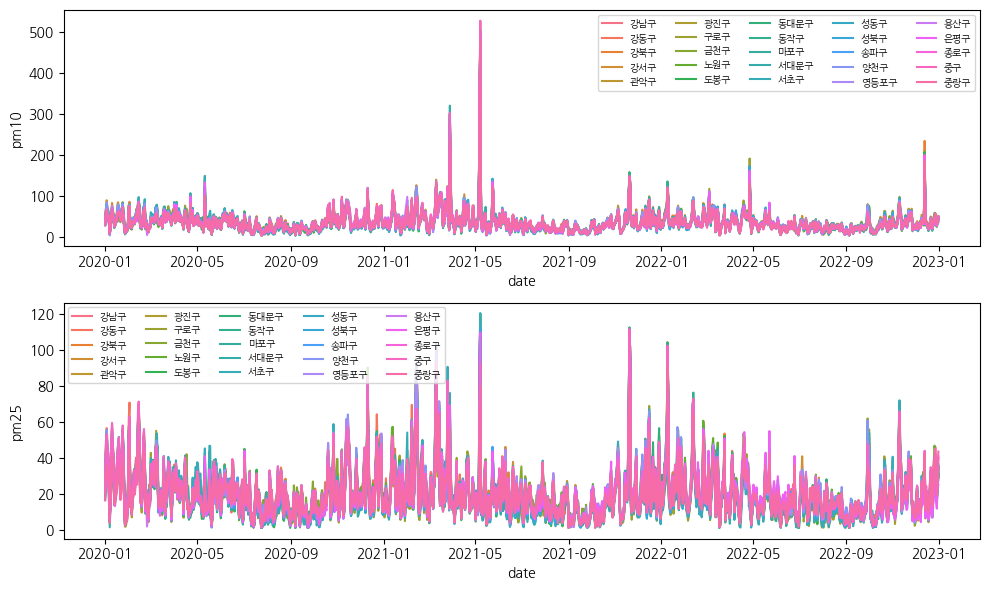

In [76]:
# EDA 날짜별 pm10, pm25 

target = df.groupby(['date','구분'])[['pm10','pm25']].mean().reset_index()

fig, axes = plt.subplots(2,1, figsize = (10, 6))
sns.lineplot(x = 'date', y = 'pm10', hue = '구분', data = target, ax = axes[0])
sns.lineplot(x = 'date', y = 'pm25', hue = '구분', data = target, ax = axes[1])

for ax in axes :
    legend = ax.get_legend()
    if legend : 
        ax.legend(fontsize = 7, ncol = 5)
plt.tight_layout()
plt.show()

In [77]:
# Pivot Table 구성 
df1 = df[['date','구분','pm10','hour']].sort_values(by = 'date').reset_index(drop = True)

pivot_df = df.pivot_table(index = ['date','구분'], columns = 'hour', values = 'pm10').reset_index()
pivot_df.head(3)

hour,date,구분,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,2020-01-01,강남구,19.0,32.0,28.0,20.0,20.0,20.0,20.0,21.0,23.0,25.0,24.0,28.0,27.0,31.0,32.0,36.0,36.0,36.0,37.0,39.0,39.0,42.0,41.0,43.0
1,2020-01-01,강동구,27.0,25.0,25.0,25.0,24.0,28.0,27.0,28.0,29.0,32.0,30.0,31.0,32.0,36.0,39.0,40.0,41.0,42.0,44.0,51.0,50.0,52.0,49.0,51.0
2,2020-01-01,강북구,21.0,32.0,30.0,33.0,29.0,35.0,32.0,33.0,31.0,31.0,33.0,37.0,40.0,44.0,41.0,45.0,48.0,50.0,50.0,51.0,48.0,50.0,50.0,55.0


pm25 데이터 구성 - 종속변수는 a+1일자의 00:00시의 해당 지역구의 pm25 값

In [88]:
df2 = df[df.hour == 0].reset_index(drop = True)
df2['date'] = pd.to_datetime(df2['date']) + pd.Timedelta(days = 1)
pm25 = df2[['date','구분','pm25']].sort_values(by ='date').reset_index(drop = True)
pm25.head()

,date,구분,pm25
0,2020-01-02,중랑구,10.0
1,2020-01-02,강남구,13.0
2,2020-01-02,강동구,18.0
3,2020-01-02,강북구,13.0
4,2020-01-02,강서구,13.0


In [90]:
m_df = pd.merge(pivot_df, pm25, how = 'outer' ) #,left_on = ['date','구분'] , right_on = ['date','구분'])

# pm25가 null이 아닌것들만 
m_df = m_df[m_df.pm25.notnull()].sort_values(by = 'date').reset_index(drop = True)

In [91]:
# 각 행별 NA값을 구하여 2개가 넘으면 제외
m2 = m_df[m_df.isnull().sum(axis = 1)<= 2].reset_index(drop = True)

In [95]:
# null 값이 있는 0 ~ 23시의 데이터의 결측값을 채우기 
m2.iloc[:,2:] = m2.iloc[:,2:].fillna(method = 'bfill', axis = 1)

✅ 2. Modelling - 회귀 분석 & KFold

In [113]:
X = m2.drop(columns = ['date','pm25'], axis = 1)
xx = pd.get_dummies(X, dtype = int)
xx.columns = xx.columns.map(lambda x : str(x)+'시' if len(str(x)) <= 2 else x)

y = m2['pm25']

In [116]:

def model_val(name, model) : 
    x_train, x_test, y_train, y_test = train_test_split(xx, y, test_size =0.3, random_state = 42)

    kfold = KFold(n_splits=5 , shuffle = True, random_state = 42)
    cv_score = cross_val_score(model, x_train, y_train, cv = kfold, scoring = 'neg_mean_squared_error')
    score = -np.mean(cv_score)

    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    mse = np.sqrt(mean_squared_error(y_test , pred))
    r2 = r2_score(y_test, pred)

    return score , mse, r2

res = []
for name, model in [['LR', LinearRegression()], ['RF',RandomForestRegressor()] , ['SVR' , SVR()]] : 
    score, mse, r2 = model_val(name, model)
    res.append([name, score, mse, r2])

result = pd.DataFrame(res, columns = ['Model','K_fold_score','MSE','R2'])
result

,Model,K_fold_score,MSE,R2
0,LR,213.748811,14.639249,0.124098
1,RF,141.280035,11.792003,0.431680
2,SVR,204.422678,14.332438,0.160428


✅ 3. GridSearch

In [125]:
# RF가 가장 높은 성능
x_train, x_test, y_train, y_test = train_test_split(xx, y, test_size =0.3, random_state = 42)

rf = RandomForestRegressor()

params = {
    'n_estimators' : [1,10,20,100],
    'max_depth' : [2,4,6,7],
    'min_samples_split' : [2,3,4],
    'min_samples_leaf' :[1,3,5],
}

rf_grid = GridSearchCV(rf, params, scoring = 'neg_mean_squared_error')
rf_grid.fit(x_train, y_train)
best_rf = rf_grid.best_estimator_ 

best_pred = best_rf.predict(x_test)
mse = np.sqrt(mean_squared_error(y_test, best_pred))

print(f'Random Forest 의 최적 모델의 성능 MSE : {mse}')

Random Forest 의 최적 모델의 성능 MSE : 12.905769320382195


AttributeError: 'RandomForestRegressor' object has no attribute 'feature_importances'

### 🔍 통계 
##### ✅ 1. 수도권 & 지방검정 - 카이제곱 
수도권(서울,경기도)과 지방(그 외)의 인허가 후 365일 이내 폐업 여부가 연관이 있는지 확인

In [149]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s1.csv')
df.head()

,인허가일자,폐업일자,상세영업상태명,소재지전체주소,사업장명
0,2014-09-24,NaN,영업중,대구광역시 달성군 다사읍 죽곡리 808-1번지 2~3층,슬림 휘트니스 클럽
1,2016-05-02,NaN,영업중,대구광역시 달성군 화원읍 구라리 1737-14번지 4층,다짐휘트니스
2,2016-05-09,NaN,영업중,대구광역시 달성군 옥포읍 교항리 2902번지,디젤 피트니스
3,2016-12-13,NaN,영업중,대구광역시 달성군 유가읍 봉리 606 하이젠스타 9층,뷰스 짐
4,2017-01-04,NaN,영업중,대구광역시 달성군 다사읍 세천리 1580-9번지 3층,다짐휘트니스


In [150]:
# 1) 도시만들기 
df['city'] = df['소재지전체주소'].str.split(' ').str[0]
df['group'] = df['city'].apply(lambda x : '수도권' if x in ['서울특별시', '경기도'] else '지방')

# 2) 일자 (폐업일자) 2025-02-28
df['인허가일자'] = pd.to_datetime(df['인허가일자'])
df['폐업일자'] = pd.to_datetime(df['폐업일자']).fillna('2025-02-28')

df['day_diff'] = (df['폐업일자'] -df['인허가일자']).dt.days 

In [151]:
# 3) 365일 이내 & 상세영업상태명가 폐업이면 - 폐업 
df['폐업유무']= df.apply(lambda x : 'close' if x['day_diff'] <= 365 and x['상세영업상태명'] == '폐업' else 'open', axis = 1)

In [152]:
# 4) 통계량 
from scipy.stats import chi2_contingency, shapiro, levene
tab = pd.crosstab(df['group'] , df['폐업유무'])
stat, p_val , _ , _ = chi2_contingency(tab)
print(p_val)

0.03265931875988032


✅ 2. 치킨 브랜드 - 시설 총 규모 (ANOVA)

In [153]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s2.csv')
df.head()

,인허가일자,사업장명,업태구분명,시설총규모,업체ID
0,2023-11-24,자담치킨,한식,186.00,ID_0
1,2023-09-27,네네치킨&봉구스밥버거 안동과학대점,호프/통닭,25.00,ID_1
2,2023-10-11,교촌치킨 봉천3호점,기타,72.00,ID_2
3,2019-01-09,맘스터치,분식,38.78,ID_3
4,2022-05-10,노랑통닭,호프/통닭,26.10,ID_4


In [154]:
df['brand'] =  df['사업장명'].apply(lambda x :  '자담' if '자담' in x else 
                                                 '굽네' if '굽네' in x else
                                                 '교촌' if '교촌' in x else 
                                                 '네네' if '네네' in x else '그외')

In [162]:
# 1) 정규성 검정 - 정규분포 아니다. 
sha = []
for name in df['brand'].unique() : 
    if name != '그외' : 
        stat, p_val = shapiro(df[df['brand'] == name]['시설총규모'])
        sha.append([name, p_val])

res = pd.DataFrame(sha,columns =['chicken', 'p_val'])
res

,chicken,p_val
0,자담,1.563991e-29
1,네네,1.386691e-41
2,교촌,3.297140e-37
3,굽네,3.015226e-39


In [163]:
# 2) 등분산 검정 
df1 = df[df['brand'] != '그외']

g = [group['시설총규모'] for name, group in df1.groupby('brand') ]
levene(*g)

LeveneResult(statistic=np.float64(220.99806381775988), pvalue=np.float64(1.1811595753193375e-135))

9.315007154309261e-182
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
    교촌     굽네 -22.2116    0.0 -25.1895 -19.2336   True
    교촌     네네 -34.0616    0.0 -37.0734 -31.0499   True
    교촌     자담 -19.9157    0.0 -23.4317 -16.3997   True
    굽네     네네 -11.8501    0.0 -15.0439  -8.6563   True
    굽네     자담   2.2959 0.3751  -1.3772    5.969  False
    네네     자담   14.146    0.0  10.4454  17.8466   True
------------------------------------------------------


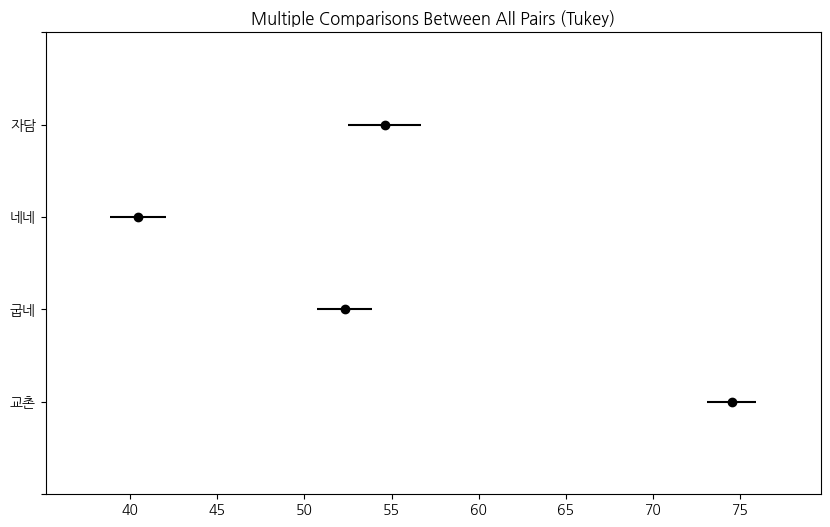

In [170]:
# 3) 일원 분산 분석 
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

groups = [df1[df1['brand'] == chicken_name]['시설총규모'] for chicken_name in df1['brand'].unique() ]
stat, p_val = f_oneway(*groups)

print(p_val)
tukey = pairwise_tukeyhsd(df1['시설총규모'],df1['brand'] , alpha = 0.05)
print(tukey)
tukey.plot_simultaneous()
plt.show()

In [179]:
# 비모수 검정) 정규성과 등분산성 불만족 - Kruskal 
from scipy.stats import kruskal
import scikit_posthocs as sp

g = [df1[df1['brand'] == name]['시설총규모'] for name in df1['brand'].unique()]
stat, p_val = kruskal(*g)
print(p_val)

# Dunn's 사후 검정 (p-value 보정: Bonferroni)
dunn_results = sp.posthoc_dunn(df1, val_col='시설총규모', group_col='brand', p_adjust='bonferroni')
print(dunn_results)

1.380065021275104e-174
               교촌            굽네             네네            자담
교촌   1.000000e+00  9.162136e-42  4.456258e-176  1.673028e-23
굽네   9.162136e-42  1.000000e+00   1.051958e-43  1.000000e+00
네네  4.456258e-176  1.051958e-43   1.000000e+00  2.901447e-40
자담   1.673028e-23  1.000000e+00   2.901447e-40  1.000000e+00


✅ 3. 요인 분석

In [182]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s3.csv')
df

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,E1,E2,E3,E4,E5,N1,N2,N3,N4,N5,O1,O2,O3,O4,O5,ID
0,2.0,4.0,3.0,4.0,4.0,2.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,4.0,4.0,3.0,4.0,2.0,2.0,3.0,3.0,6,3.0,4.0,3.0,ID_0
1,2.0,4.0,5.0,2.0,5.0,5.0,4.0,4.0,3.0,4.0,1.0,1.0,6.0,4.0,3.0,3.0,3.0,3.0,5.0,5.0,4.0,2,4.0,3.0,3.0,ID_1
2,5.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,2.0,5.0,2.0,4.0,4.0,4.0,5.0,4.0,5.0,4.0,2.0,3.0,4.0,2,5.0,5.0,2.0,ID_2
3,4.0,4.0,6.0,5.0,5.0,4.0,4.0,3.0,5.0,5.0,5.0,3.0,4.0,4.0,4.0,2.0,5.0,2.0,4.0,1.0,3.0,3,4.0,3.0,5.0,ID_3
4,2.0,3.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,2.0,2.0,2.0,5.0,4.0,5.0,2.0,3.0,4.0,4.0,3.0,3.0,3,4.0,3.0,3.0,ID_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2431,3.0,4.0,3.0,1.0,3.0,5.0,4.0,5.0,3.0,4.0,3.0,5.0,2.0,3.0,1.0,5.0,6.0,5.0,5.0,6.0,6.0,1,4.0,5.0,2.0,ID_2431
2432,5.0,5.0,5.0,5.0,3.0,5.0,4.0,2.0,3.0,5.0,3.0,5.0,5.0,6.0,5.0,4.0,5.0,3.0,5.0,2.0,6.0,1,5.0,6.0,2.0,ID_2432
2433,2.0,3.0,5.0,2.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0,6.0,3.0,6.0,3.0,4.0,3.0,3.0,1.0,5.0,1,6.0,4.0,3.0,ID_2433
2434,5.0,2.0,2.0,4.0,4.0,5.0,5.0,5.0,2.0,6.0,2.0,2.0,4.0,5.0,4.0,5.0,5.0,6.0,4.0,1.0,5.0,2,5.0,5.0,1.0,ID_2434


In [183]:
# 1) 변수간 상관 행렬 확인 - KMO > 0.7
# 귀무가설 : 상관행렬이 단위행렬 (변수간 상관성 없다)
# 대립가설 : 상관행렬이 단위행렬이 아니다 (변수간 상관성 있다) > 요인분석 가능 

f_df = df.drop(columns = ['ID'], axis = 1)
kmo, kmo_model = calculate_kmo(f_df)
print(kmo_model)

0.8486452309468394


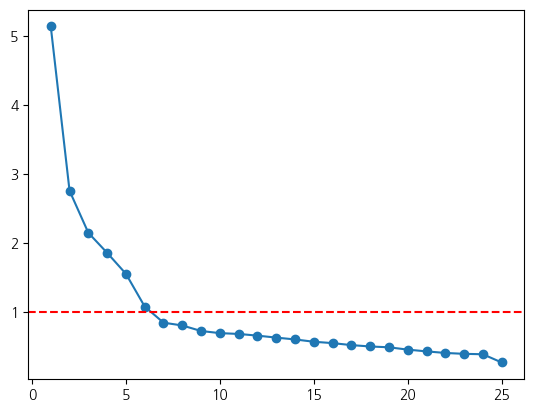


Eigen Value 1 이상인 지점 까지로 factor를 선정 총 6개 



In [191]:
#2) Factor Analysis 
fa = FactorAnalyzer(n_factors=25, rotation=None) #,rotation=None 없으면 매트릭스 오류
fa.fit(f_df) 

# eigen value
ev, v = fa.get_eigenvalues()

plt.scatter(range(1, f_df.shape[1] + 1), ev)
plt.plot(range(1,f_df.shape[1]+1),ev)
plt.axhline(1, color = 'red', linestyle = '--')
plt.show()

print('''
Eigen Value 1 이상인 지점 까지로 factor를 선정 총 6개 
''')

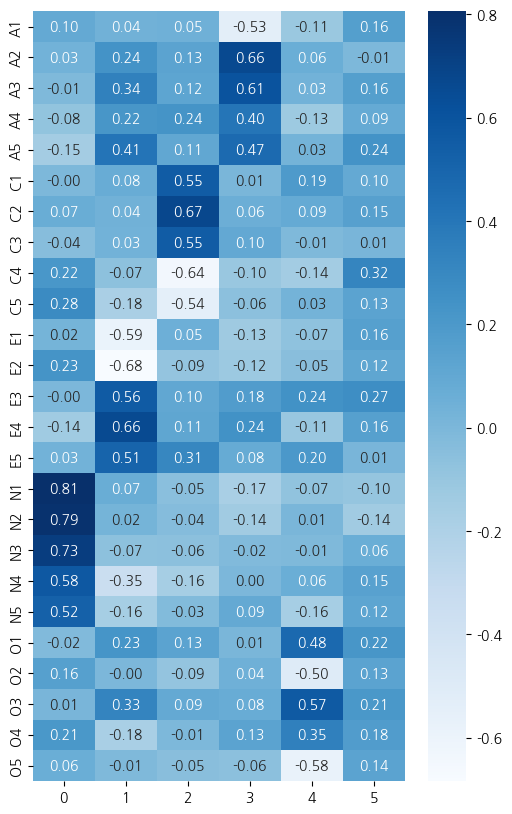

In [193]:
fa = FactorAnalyzer(n_factors=6, rotation="varimax") #ml : 최대우도 방법
fa.fit(f_df)
fa_result= pd.DataFrame(fa.loadings_, index=f_df.columns)
plt.figure(figsize=(6,10))
sns.heatmap(fa_result, cmap="Blues", annot=True, fmt='.2f')
plt.show()